# Download the test data and model (resnet50)

In [1]:
import os
import urllib

def download(base_url, filename):
    if os.path.exists(f'downloads/{filename}'):
        return
    print(f'Downloading {filename}')
    os.makedirs('downloads', exist_ok=True)
    urllib.request.urlretrieve(f'{base_url}{filename}', f'downloads/{filename}')

download('https://github.com/onnx/models/raw/master/vision/classification/resnet/model/', 'resnet50-v2-7.onnx')
download('https://github.com/onnx/models/raw/master/vision/classification/', 'synset.txt')
download('https://raw.githubusercontent.com/pytorch/hub/master/images/', 'dog.jpg')

# Load the test image and class labels

Loaded 1000 labels
Tensor shape: (1, 3, 224, 224) float32


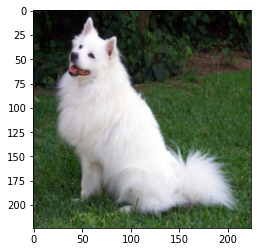

In [2]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

mean_vec = np.array([0.485, 0.456, 0.406])
stddev_vec = np.array([0.229, 0.224, 0.225])

def to_tensor(im):
    im = np.transpose(im, [2, 0, 1]) # HWC -> CHW
    t = np.zeros(im.shape, dtype=np.float32)
    for i in range(im.shape[0]):
        t[i, :, :] = (im[i, :, :].astype(np.float32) / 255 - mean_vec[i]) / stddev_vec[i] # Normalize
    return np.expand_dims(t, axis=0) # CHW -> NCHW

with open('downloads/synset.txt', 'r') as f:
    labels = [l.rstrip() for l in f]
print(f'Loaded {len(labels)} labels')    
    
image = Image.open('downloads/dog.jpg')
image = np.array(image.resize((224, 224), Image.BILINEAR))
X = to_tensor(image)
print(f'Tensor shape: {X.shape} {X.dtype}')
plt.imshow(image);

# Run ONNX inference on CPU

In [3]:
from onnxruntime import SessionOptions, GraphOptimizationLevel, InferenceSession

def softmax(x):
    y = np.exp(x - np.max(x))
    return y / np.sum(y)

def infer(session):
    input = session.get_inputs()[0].name
    scores = session.run(None, {input: X})[0][0]
    return softmax(scores)

def print_top_classes(probas):
    classes = np.argsort(probas)[::-1]
    for i in range(5):
        print(f'Proba = {probas[classes[i]]:5.2f}, class = {labels[classes[i]]}')
    
session = InferenceSession('downloads/resnet50-v2-7.onnx', providers = ['CPUExecutionProvider'])
probas = infer(session)
print_top_classes(probas)

Proba =  0.93, class = n02111889 Samoyed, Samoyede
Proba =  0.03, class = n02112350 keeshond
Proba =  0.02, class = n02112018 Pomeranian
Proba =  0.01, class = n02111500 Great Pyrenees
Proba =  0.01, class = n02112137 chow, chow chow


# Run ONNX inference on GPU (DirectML)

In [5]:
# Other execution providers available: CUDAExecutionProvider, ROCMExecutionProvider, MIGraphXExecutionProvider, TensorrtExecutionProvider
session = InferenceSession('downloads/resnet50-v2-7.onnx', providers = ['DmlExecutionProvider'])
probas = infer(session)
print_top_classes(probas)

Proba =  0.93, class = n02111889 Samoyed, Samoyede
Proba =  0.03, class = n02112350 keeshond
Proba =  0.02, class = n02112018 Pomeranian
Proba =  0.01, class = n02111500 Great Pyrenees
Proba =  0.01, class = n02112137 chow, chow chow


# Benchmark CPU vs GPU inference

In [6]:
session = InferenceSession('downloads/resnet50-v2-7.onnx', providers = ['CPUExecutionProvider'])
input = session.get_inputs()[0].name

In [7]:
%timeit -n 20 -r 10 session.run(None, {input: X})

48.7 ms ± 2.85 ms per loop (mean ± std. dev. of 10 runs, 20 loops each)


In [8]:
session = InferenceSession('downloads/resnet50-v2-7.onnx', providers = ['DmlExecutionProvider'])
input = session.get_inputs()[0].name

In [9]:
%timeit -n 20 -r 10 session.run(None, {input: X})

46.6 ms ± 305 µs per loop (mean ± std. dev. of 10 runs, 20 loops each)


And it looks like on Intel UHD Graphics GPU acceleration is not much of an acceleration...